In [1]:
import sys
import tqdm
import sklearn
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
import torch
import torch.nn.functional as F
import random
import networkx as nx
import collections
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from load_dataset import load
from classifier import NeuralNetwork, LogisticRegression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from scipy import stats
from scipy.stats import rankdata
from sklearn import metrics, preprocessing, mixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from torch.autograd import grad
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore') 

**Load Dataset**

In [3]:
dataset = 'german'
X_train, X_test, y_train, y_test = load(dataset, preprocess=False)
X_train_no_preprocess = copy.deepcopy(X_train)
X_test_no_preprocess = copy.deepcopy(X_test)
X_train, X_test, y_train, y_test = load(dataset, preprocess=True)

**Parametric Model**

In [4]:
# size=500
# X_train = X_train[0:size]
# y_train = y_train[0:size]

X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data: regularization penalty default: ‘l2’, ‘lbfgs’ solvers support only l2 penalties. 
# Regularization makes the predictor dependent on the scale of the features.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Loss function** (Log loss for logistic regression)

In [5]:
# clf = NeuralNetwork()
clf = LogisticRegression(input_size=X_train.shape[-1])
# clf = SVM()
num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, LogisticRegression) or isinstance(clf, NeuralNetwork):
#     loss_func = lambda model, x, y_true: logistic_loss_torch(model(torch.FloatTensor(x)),\
#                                                              torch.FloatTensor([y_true])) +\
#     model.C*torch.sqrt(torch.sum(convert_grad_to_tensor(list(clf.parameters()))**2))
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch

**Influence of points computed using ground truth**

In [6]:
def ground_truth_influence(X_train, y_train, X_test, X_test_orig, y_test):
    clf.fit(X_train, y_train, verbose=True)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig, y_test, 0)

    delta_spd = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_i = computeFairness(y_pred, X_test_orig, y_test, 0) - spd_0
        delta_spd.append(delta_spd_i)

    return delta_spd

**Compute Accuracy** 

In [7]:
def computeAccuracy(y_true, y_pred):
    return np.sum((y_pred>0.5) == y_true)/len(y_pred)

**First-order derivative of loss function at z with respect to model parameters**

In [8]:
def del_L_del_theta_i(model, x, y_true, retain_graph=False):
    loss = loss_func(model, x, y_true)
    w = [ p for p in model.parameters() if p.requires_grad ]
    return grad(loss, w, create_graph=True, retain_graph=retain_graph)

**First-order derivative of $P(y \mid \textbf{x})$ with respect to model parameters**

In [9]:
def del_f_del_theta_i(model, x, retain_graph=False):
    w = [ p for p in model.parameters() if p.requires_grad ]
    return grad(model(torch.FloatTensor(x)), w, retain_graph=retain_graph)

**Stochastic estimation of Hessian vector product (involving del fairness): $H_{\theta}^{-1}v = H_{\theta}^{-1}\nabla_{\theta}f(z, \theta) = v + [I - \nabla_{\theta}^2L(z_{s_j}, \theta^*)]H_{\theta}^{-1}v$**

In [10]:
def hvp(y, w, v):
    ''' Multiply the Hessians of y and w by v.'''
    # First backprop
    first_grads = grad(y, w, retain_graph=True, create_graph=True)

    # Elementwise products
    elemwise_products = 0
    for grad_elem, v_elem in zip(convert_grad_to_tensor(first_grads), v):
        elemwise_products += torch.sum(grad_elem * v_elem)

    # Second backprop
    return_grads = grad(elemwise_products, w, create_graph=True)

    return return_grads

In [11]:
def hessian_one_point(model, x, y):
    x, y = torch.FloatTensor(x), torch.FloatTensor([y])
    loss = loss_func(model, x, y)
    params = [ p for p in model.parameters() if p.requires_grad ]
    first_grads = convert_grad_to_tensor(grad(loss, params, retain_graph=True, create_graph=True))
    hv = np.zeros((len(first_grads), len(first_grads)))
    for i in range(len(first_grads)):
        hv[i, :] = convert_grad_to_ndarray(grad(first_grads[i], params, create_graph=True)).ravel()
    return hv

In [12]:
# Compute multiplication of inverse hessian matrix and vector v
def s_test(model, xs, ys, v, damp=0.01, scale=25.0, r=-1, batch_size=-1, recursive=False, verbose=False):
    ''' Arguments:
        xs: list of data points
        ys: list of true labels corresponding to data points in xs
        damp: dampening factor
        scale: scaling factor
        r: number of iterations aka recursion depth
            should be enough so that the value stabilises.
        batch_size: number of instances in each batch in recursive approximation
        recursive: determine whether to recursively approximate hinv_v'''
    xs, ys = torch.FloatTensor(xs.copy()), torch.FloatTensor(ys.copy())
    n = len(xs)
    hinv_v = copy.deepcopy(v)
    if recursive:
        if verbose:
            print('Computing s_test...')
            tbar = tqdm.tqdm(total=r)
        if (batch_size == -1):  # default
            batch_size = 10
        if (r == -1):
            r = n // batch_size + 1
        sample = np.random.choice(range(n), r*batch_size, replace=True)
        for i in range(r):
            sample_idx = sample[i*batch_size:(i+1)*batch_size]
            x, y = xs[sample_idx], ys[sample_idx]
            loss = loss_func(model, x, y)
            params = [ p for p in model.parameters() if p.requires_grad ]
            hv = convert_grad_to_ndarray(hvp(loss, params, torch.FloatTensor(hinv_v)))
            # Recursively caclulate h_estimate
            hinv_v = v + (1 - damp) * hinv_v - hv / scale
            if verbose:
                tbar.update(1)
    else:
        scale = 1.0
        hinv = np.linalg.pinv(np.sum(hessian_all_points, axis=0))
        hinv_v = np.matmul(hinv, v)

    return hinv_v / scale

**First-order influence computation**

In [13]:
def first_order_influence(del_L_del_theta, hinv_v, n):
    infs = []
    for i in range(n):
        inf = -np.dot(del_L_del_theta[i].transpose(), hinv_v)
        inf *= -1/n
        infs.append(inf)
    return infs

**Second-order influence computation for a group of points in subset U**

In [14]:
def second_order_influence(model, X_train, y_train, U, del_L_del_theta, r=-1, verbose=False):
    u = len(U)
    s = len(X_train)
    p = u/s
    c1 = (1 - 2*p)/(s * (1-p)**2)
    c2 = 1/((s * (1-p))**2)
    num_params = len(del_L_del_theta[0])
    del_L_del_theta_sum = np.sum([del_L_del_theta[i] for i in U], axis=0)
    hinv_del_L_del_theta= s_test(model, X_train, y_train, del_L_del_theta_sum)
    hessian_U_hinv_del_L_del_theta = np.zeros((num_params,))
    for i in range(u):
        idx = U[i]
        x, y = torch.FloatTensor(X_train[idx]), torch.FloatTensor([y_train[idx]])
        loss = loss_func(model, x, y)
        params = [ p for p in model.parameters() if p.requires_grad ]
        hessian_U_hinv_del_L_del_theta += convert_grad_to_ndarray(hvp(loss, params, torch.FloatTensor(hinv_del_L_del_theta)))

    term1 = c1 * hinv_del_L_del_theta
    term2 = c2 * s_test(model, X_train, y_train, hessian_U_hinv_del_L_del_theta)
    sum_term = term1 + term2
    return sum_term

**Metrics: Initial state**

In [15]:
clf = LogisticRegression(input_size=X_train.shape[-1])
# clf = NeuralNetwork()
# clf = SVM()

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.11221257965080444
Initial TPR parity:  -0.0865221897550269
Initial predictive parity:  -0.09399734250421976
Initial loss:  0.5060894865816397
Initial accuracy:  0.755


In [16]:
hessian_all_points = []
tbar = tqdm.tqdm(total=len(X_train))
for i in range(len(X_train)):
    hessian_all_points.append(hessian_one_point(clf, X_train[i], y_train[i])/len(X_train))
    tbar.update(1)

100%|█████████▉| 797/800 [00:16<00:00, 44.62it/s]

**Pre-compute: (1) Hessian (2) del_L_del_theta for each training data point**

In [17]:
del_L_del_theta = []
for i in range(int(len(X_train))):
    del_L_del_theta.append(convert_grad_to_ndarray(del_L_del_theta_i(clf, X_train[i], y_train[i])))

*Select delta fairness function depending on selected metric*

In [18]:
metric = 0
if metric == 0:
    v1 = del_spd_del_theta(clf, X_test_orig, X_test, dataset)
elif metric == 1:
    v1 = del_tpr_parity_del_theta(clf, X_test_orig, X_test, y_test, dataset)
elif metric == 2:
    v1 = del_predictive_parity_del_theta(clf, X_test_orig, X_test, y_test, dataset)

In [19]:
hinv_v = s_test(clf, X_train, y_train, v1, verbose=False)

**First-order influence of each training data point**

In [20]:
infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))

100%|██████████| 800/800 [00:30<00:00, 44.62it/s]

**Checking ground truth, first-order and second-order influences for a set**

In [21]:
metric = 0
if metric == 0:
    print("Statistical parity ")
elif metric == 1:
    print("True positive rate parity ")
elif metric == 2:
    print("Predictive parity")
    
active = 1
if active:
    if dataset == 'german':
        predicates = ['age']
    elif dataset == 'adult':
        predicates = ['gender_Male']
    elif dataset == 'compas':
        predicates = ['race']
    idx = X_train_orig.index 
    for pred in predicates:
        idx0 = X_train_orig[(X_train_orig[pred] == 1)].index 
        idx = idx.intersection(idx0)

    del_f_1 = 0
    for i in range(len(idx)):
        del_f_1 += infs_1[idx[i]]
    print("First-order influence: ", del_f_1)

    params_f_2 = second_order_influence(clf, X_train, y_train, idx, del_L_del_theta)
    del_f_2 = np.dot(v1.transpose(), params_f_2)
    print("Second-order influence: ", del_f_2)
    
    print("#Rows removed: ", len(idx))
    print("#Rows left: ", len(X_train) - len(idx))
    X = np.delete(X_train, idx, 0)
    y = y_train.drop(index=idx, inplace=False)
    clf.fit(np.array(X), np.array(y))
    y_pred_test = clf.predict_proba(X_test)
    print("Ground truth influence of subset (on statistical parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset) - spd_0)
    print("Ground truth influence of subset (on tpr parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset) - tpr_parity_0)
    print("Ground truth influence of subset (on predictive parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset) - predictive_parity_0)
    
    spd_1 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Ground truth statistical parity after removing subset: ", spd_1)
    
    tpr_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Ground truth tpr parity after removing subset: ", tpr_parity_1)

    predictive_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Ground truth predictive parity after removing subset: ", predictive_parity_1)

    loss_1 = logistic_loss(y_test, y_pred_test)
    print("Loss after removing subset: ", loss_1)

    accuracy_1 = computeAccuracy(y_test, y_pred_test)
    print("Accuracy after removing subset: ", accuracy_1)

Statistical parity 
First-order influence:  0.00837110859216301
Second-order influence:  0.01315796914293979
#Rows removed:  161
#Rows left:  639
Ground truth influence of subset (on statistical parity):  0.19263299787417054
Ground truth influence of subset (on tpr parity):  0.17930929952967534
Ground truth influence of subset (on predictive parity):  -0.03118482144800594
Ground truth statistical parity after removing subset:  0.0804204182233661
Ground truth tpr parity after removing subset:  0.09278710977464844
Ground truth predictive parity after removing subset:  0.09278710977464844
Loss after removing subset:  0.5218575578539789
Accuracy after removing subset:  0.735


**Fairness: Ground-truth subset influence vs. computed subset influences: Random subset**

In [22]:
# print("Ground-truth subset, Add 1st-order inf individual, Second-order subset influence")
# sampleSize = int(.2 * len(X_train))
# for i in range(100):
#     idx = random.sample(range(1, len(X_train)), sampleSize) 
    
#     # Ground truth subset influence
#     X = np.delete(X_train, idx, 0)
#     y = y_train.drop(index=idx, inplace=False)
#     clf.fit(X, y, learning_rate=.05)
#     y_pred_test = clf.predict_proba(X_test)
#     inf_gt = computeFairness(y_pred_test, X_test_orig, y_test, 0) - spd_0

#     # First-order subset influence
#     del_f_1 = 0
#     for j in range(len(idx)):
#         del_f_1 += infs_1[idx[j]]
    
#     # Second-order subset influence
#     size_hvp = 1
#     params_f_2 = second_order_influence(clf, X_train, y_train, idx, del_L_del_theta, r=5000)
#     del_f_2 = np.dot(v1.transpose(), params_f_2)

#     print(inf_gt, del_f_1, del_f_2, sep=", ")

**Fairness: Ground-truth subset influence vs. computed subset influences: Coherent subset** 

(by coherent, we mean group of data points that share some properties)

***NOTE:*** The retraining of the clf would cause the change in model parameters and thus lead to the change of gradients, so in this part, we create a single-use model which copied weights from the originally trained model for computing the ground truth influence.

In [23]:
# Get the original model
clf = LogisticRegression(input_size=X_train.shape[-1])
clf.fit(X_train, y_train)

In [24]:
n_component = 14
gmm_model = mixture.GaussianMixture(n_component, covariance_type='full', random_state=0).fit(X_train)
X_train_orig['cluster'] = gmm_model.predict(X_train)

In [25]:
def compute_inf(drop_idx):
    clf_new = LogisticRegression(input_size=X_train.shape[-1])
    clf_new.load_weights_from_another_model(clf)
    X = np.delete(X_train, drop_idx, 0)
    y = y_train.drop(index=drop_idx, inplace=False)
    clf_new.fit(np.array(X), np.array(y))
    y_pred = clf_new.predict_proba(np.array(X_test))
    acc = computeAccuracy(np.array(y_test), y_pred)
    loss = loss_func(clf_new, np.array(X_test), np.array(y_test)).detach().numpy()
    if metric == 0:
        inf_gt = computeFairness(y_pred, X_test_orig, y_test, 0, dataset) - spd_0
    elif metric == 1:
        inf_gt = computeFairness(y_pred, X_test_orig, y_test, 1, dataset) - tpr_parity_0
    elif metric == 2:
        inf_gt = computeFairness(y_pred, X_test_orig, y_test, 2, dataset) - predictive_parity_0
    # First-order subset influence
    del_f_1 = 0            
    for i in range(len(drop_idx)):
        del_f_1 += infs_1[drop_idx[i]]

    # Second-order subset influence
    params_f_2 = second_order_influence(clf, X_train, y_train, drop_idx, del_L_del_theta)
    del_f_2 = np.dot(v1.transpose(), params_f_2)

    return inf_gt, del_f_1, del_f_2, acc, loss

def compute_mu_sigma(cluster_ids):
    subset_idxs = X_train_orig[X_train_orig['cluster']==int(cluster_ids[0])].index
    if len(cluster_ids) > 1:
        for cluster_id in cluster_ids[1:]:
            subset_idxs = subset_idxs.union(X_train_orig[X_train_orig['cluster']==cluster_id].index)
        # re-estimate mean and covariance
        re_est_model = mixture.GaussianMixture(1, covariance_type='full', random_state=0).fit(X_train[subset_idxs])
        mu = re_est_model.means_[0]
        sigma = re_est_model.covariances_[0]
    else:
        cluster_id = cluster_ids[0]
        mu, sigma = gmm_model.means_[cluster_id], gmm_model.covariances_[cluster_id]
    return mu, sigma

In [26]:
# networkx visualization, FROM: https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [27]:
def KL(mu1, sigma1, mu2, sigma2):
    return 1/2*(np.log(np.linalg.det(sigma2)/np.linalg.det(sigma1))\
                - len(mu1) + np.dot(np.dot((mu1-mu2).T, np.linalg.inv(sigma2)), (mu1-mu2))\
               + np.trace(np.dot(np.linalg.inv(sigma2), sigma1)))

In [28]:
# calculate influence func for all single cluster
gts = []
firsts = []
seconds = []
acc_losses = []

for idx in range(n_component):
    gt, first, second, acc, loss = compute_inf(drop_idx=(X_train_orig[X_train_orig['cluster']==idx].index))
    gts.append(gt)
    firsts.append(first)
    seconds.append(second)
    acc_losses.append((acc, loss))

In [29]:
# build tree from bottom up based on heuristics
G = nx.DiGraph()
remain = set(range(n_component))
pool = collections.OrderedDict()
record_pool = collections.OrderedDict()
iter_cnt = 0

y_pred = clf.predict_proba(np.array(X_test))
acc_0 = computeAccuracy(np.array(y_test), y_pred)
loss_0 = loss_func(clf, np.array(X_test), np.array(y_test)).detach().numpy()

for i in range(n_component):
    G.add_node(str(i))
    mu, sigma = compute_mu_sigma(cluster_ids=[i])
    pool[str(i)] = (gts[i], firsts[i], seconds[i], mu, sigma, *acc_losses[i])
    record_pool[str(i)] = (gts[i], firsts[i], seconds[i], mu, sigma, *acc_losses[i])
while len(pool.values()) > 1:
    if len(pool.values()) == 2:
        name1, name2 = list(pool.keys())
        merged_name = 'All'
        G.add_node(merged_name)  # root
        G.add_edge(merged_name, name1)
        G.add_edge(merged_name, name2)
        break
    merged_flag = 0
    max_inf_idx = np.argmax([t[2] for t in pool.values()])
    max_name = list(pool.keys())[max_inf_idx]
    cluster_id_ls = [int(name) for name in max_name.split('_')]
    mu1, sigma1 = pool[max_name][3:5]
    data_idx = X_train_orig[X_train_orig['cluster']==int(cluster_id_ls[0])].index
    if len(cluster_id_ls) > 1:
        for cluster_id in cluster_id_ls[1:]:
            data_idx = data_idx.union(X_train_orig[X_train_orig['cluster']==cluster_id].index)
    
    KLs = [KL(mu1, sigma1, mu2, sigma2) for mu2, sigma2 in [(t[3], t[4]) for t in pool.values()]]
    best_match_idx = np.argmax(KLs)
    best_match_name = list(pool.keys())[best_match_idx]
    merged_name = max_name + '_' + best_match_name
    merged_cluster_id_ls = cluster_id_ls + [int(name) for name in merged_name.split('_')]
    merged_idx = X_train_orig[X_train_orig['cluster']==int(merged_cluster_id_ls[0])].index
    for cluster_id in merged_cluster_id_ls[1:]:
        merged_idx = merged_idx.union(X_train_orig[X_train_orig['cluster']==cluster_id].index)

    gt, first, second, acc, loss = compute_inf(drop_idx=merged_idx)
    mu, sigma = compute_mu_sigma(cluster_ids=merged_cluster_id_ls)
    pool[merged_name] = (gt, first, second, mu, sigma, acc, loss)
    record_pool[merged_name] = (gt, first, second, mu, sigma, acc, loss)
    pool.pop(max_name)
    pool.pop(best_match_name)
    if len(max_name.split('_')) == 1:
        remain.remove(int(max_name))
    if len(best_match_name.split('_')) == 1:
        remain.remove(int(best_match_name))
    
    G.add_node(merged_name)  # root
    G.add_edge(merged_name, max_name)
    G.add_edge(merged_name, best_match_name)
    iter_cnt += 1
    if iter_cnt % 5 == 0:
        print(f'iter{iter_cnt}: remain individual: {len(remain)}')

iter5: remain individual: 7
iter10: remain individual: 2


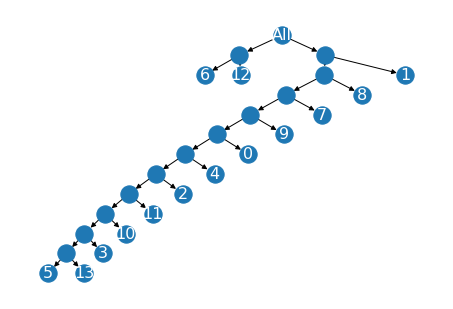

In [30]:
# pos = hierarchy_pos(G, 'All')
pos = graphviz_layout(G, prog='dot', root='All')
nx.draw(G, pos, with_labels=False, arrows=True)
labels = {}    
for node in G.nodes():
    if len(node.split('_'))==1:
        #set the node name as the key and the label as its value 
        labels[node] = node
nx.draw_networkx_labels(G, pos,labels, font_size=16, font_color='w')
plt.show()

In [31]:
names = G.nodes()
nodes = []
first_infs = []
second_infs = []
gt_infs = []
fractionRows = []
accs = []
losses = []
for node in names:
    if node != 'All':
        info = record_pool[node]
        nodes.append(node)
        gt_infs.append(info[0])
        first_infs.append(info[1])
        second_infs.append(info[2])
        accs.append(info[5])
        losses.append(info[6])

        cluster_ids = node.split('_')
        idxs = X_train_orig[X_train_orig['cluster']==int(cluster_ids[0])].index
        if len(cluster_ids) > 1:
            for cluster_id in cluster_ids:
                idxs = idxs.union(X_train_orig[X_train_orig['cluster']==int(cluster_id)].index)
        fractionRows.append(len(idxs)/len(X_train_orig))

In [32]:
expl = [nodes, first_infs, second_infs, gt_infs, fractionRows, accs, losses]
expl = (np.array(expl).T).tolist()
explanations = pd.DataFrame(expl, columns=["node", "first_order_influences", "second_order_influences", "gt_influences", "fractionRows", "accuracies", "losses"])

In [33]:
explanations.sort_values(by=['second_order_influences'], ascending=False)

,node,first_order_influences,second_order_influences,gt_influences,fractionRows,accuracies,losses
25,5_13_3_10_11_2_4_0_9_7_8_1,-0.00976025684234589,0.1548004977653079,-0.08780220774024194,0.90625,0.605,0.89788306
24,5_13_3_10_11_2_4_0_9_7_8,-0.01404526785278566,0.0843766782510098,-0.08836673742189305,0.87625,0.66,0.65509737
18,5_13_3_10_11,0.027225481216634283,0.04746845146542663,0.048989158449694536,0.34375,0.725,0.5425491
20,5_13_3_10_11_2_4,0.016896009722561712,0.04522658712975479,0.03778258576057858,0.51125,0.73,0.5312014
19,5_13_3_10_11_2,0.016368625843613604,0.03991721165965768,0.0357318644644693,0.4325,0.735,0.5342085
21,5_13_3_10_11_2_4_0,0.011660086029725734,0.03930025377479199,0.027224369603209286,0.595,0.72,0.5282197
22,5_13_3_10_11_2_4_0_9,-0.003857813223377335,0.038118381625429854,0.05550597930996448,0.68125,0.7,0.6057876
23,5_13_3_10_11_2_4_0_9_7,-0.007225102287880478,0.03682645610796986,-0.025475812227159556,0.82,0.73,0.71182895
15,5_13_3,0.015688910231261028,0.02739596375999312,0.026469978131353877,0.28875,0.73,0.542212
14,5_13,0.015440875220330922,0.027103042372616112,0.024458888079971097,0.27625,0.74,0.53787196


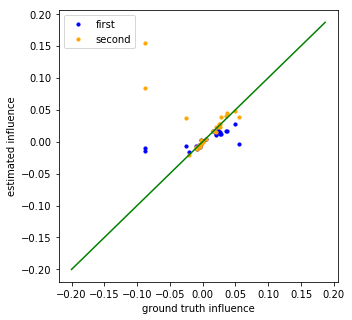

In [34]:
plt.figure(figsize=(5,5))
xs = (np.arange(30)-15)/15*0.2
ys = xs
# plt.xlim(-0.06, 0.04)
# plt.ylim(-0.03, 0.03)
plt.plot(xs, ys, 'g')
plt.scatter(gt_infs, first_infs, s=10, c='blue', label='first')
plt.scatter(gt_infs, second_infs, s=10, c='orange', label='second')
plt.xlabel('ground truth influence')
plt.ylabel('estimated influence')
plt.legend()

In [35]:
deviation = np.abs(np.array(second_infs)-np.array(gt_infs))
outliers = dict()
for node_idx, node in enumerate(nodes):
    # outliers
    if deviation[node_idx] > 0.03:
        outliers[node] = node

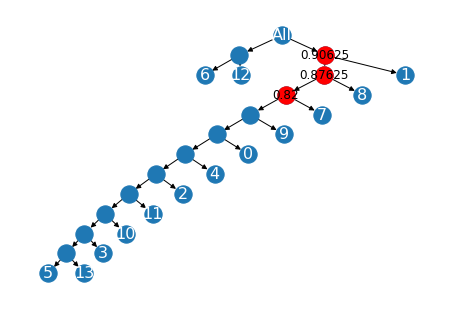

In [36]:
pos = graphviz_layout(G, prog='dot', root='All')
nx.draw(G, pos, with_labels=False, arrows=True)
labels = dict() 
for node in G.nodes():
    if len(node.split('_'))==1:
        #set the node name as the key and the label as its value 
        labels[node] = node
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='w')

outlier_labels = dict() 
for node_idx, node in list(enumerate(G.nodes()))[:-1]:
    if node in outliers:
        #set the node name as the key and the label as its value 
        outlier_labels[node] = fractionRows[node_idx]
nx.draw_networkx_nodes(G, pos, outliers, node_color='r')
nx.draw_networkx_labels(G, pos, outlier_labels, font_color='black')
plt.show()

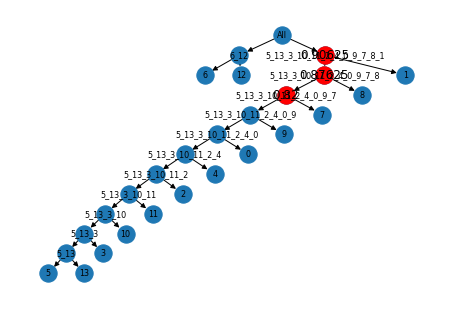

In [37]:
pos = graphviz_layout(G, prog='dot', root='All')
nx.draw(G, pos, with_labels=False, arrows=True)
labels = dict() 
for node in G.nodes():
    #set the node name as the key and the label as its value 
    labels[node] = node
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='black')

outlier_labels = dict() 
for node_idx, node in list(enumerate(G.nodes()))[:-1]:
    if node in outliers:
        #set the node name as the key and the label as its value 
        outlier_labels[node] = fractionRows[node_idx]
nx.draw_networkx_nodes(G, pos, outliers, node_color='r')
nx.draw_networkx_labels(G, pos, outlier_labels, font_color='black')
plt.show()

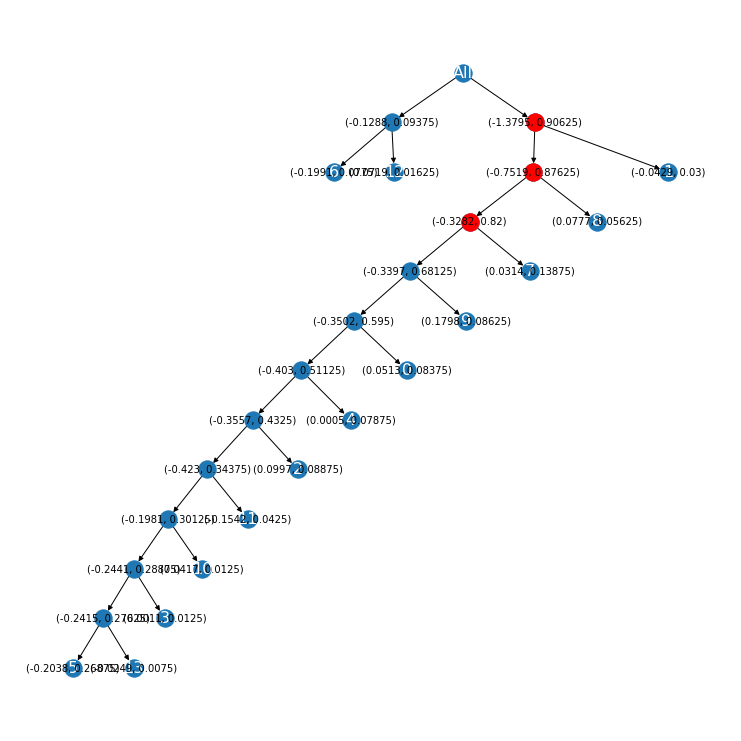

In [38]:
# show bias reduction
plt.figure(figsize=(10,10))
pos = graphviz_layout(G, prog='dot', root='All')
nx.draw(G, pos, with_labels=False, arrows=True)
labels = dict() 
for node in G.nodes():
    if len(node.split('_'))==1:
        #set the node name as the key and the label as its value 
        labels[node] = node
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='w')

bias_reduction_fraction_labels = dict() 
for node_idx, node in list(enumerate(G.nodes()))[:-1]:
    bias_reduction_fraction_labels[node] = (round(second_infs[node_idx]/spd_0,4), fractionRows[node_idx])
nx.draw_networkx_nodes(G, pos, outliers, node_color='r')
nx.draw_networkx_labels(G, pos, bias_reduction_fraction_labels, font_color='black', font_size=10)
plt.show()

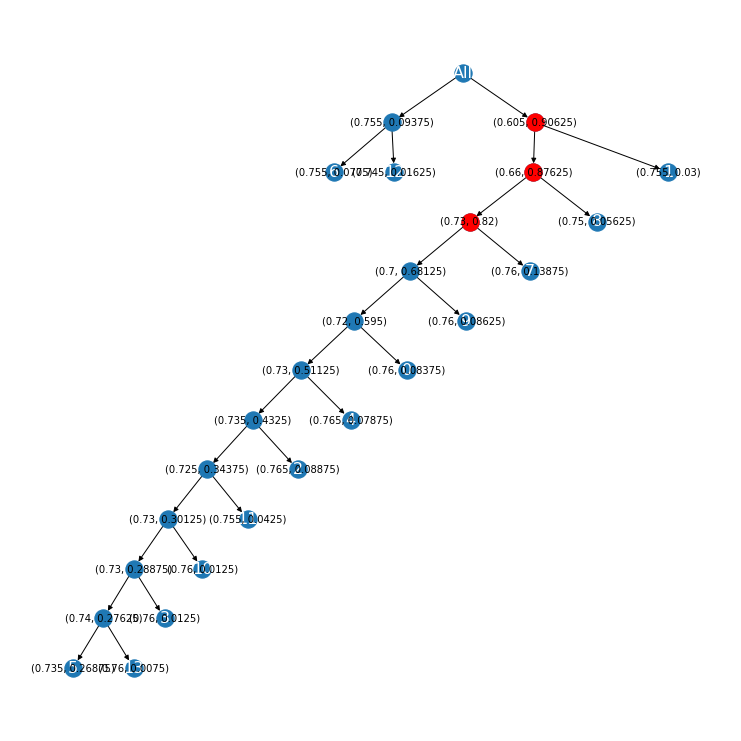

In [39]:
# show acc
plt.figure(figsize=(10,10))
pos = graphviz_layout(G, prog='dot', root='All')
nx.draw(G, pos, with_labels=False, arrows=True)
labels = dict() 
for node in G.nodes():
    if len(node.split('_'))==1:
        #set the node name as the key and the label as its value 
        labels[node] = node
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='w')

acc_labels = dict() 
for node_idx, node in list(enumerate(G.nodes()))[:-1]:
    acc_labels[node] = (accs[node_idx], fractionRows[node_idx])
nx.draw_networkx_nodes(G, pos, outliers, node_color='r')
nx.draw_networkx_labels(G, pos, acc_labels, font_color='black', font_size=10)
plt.show()

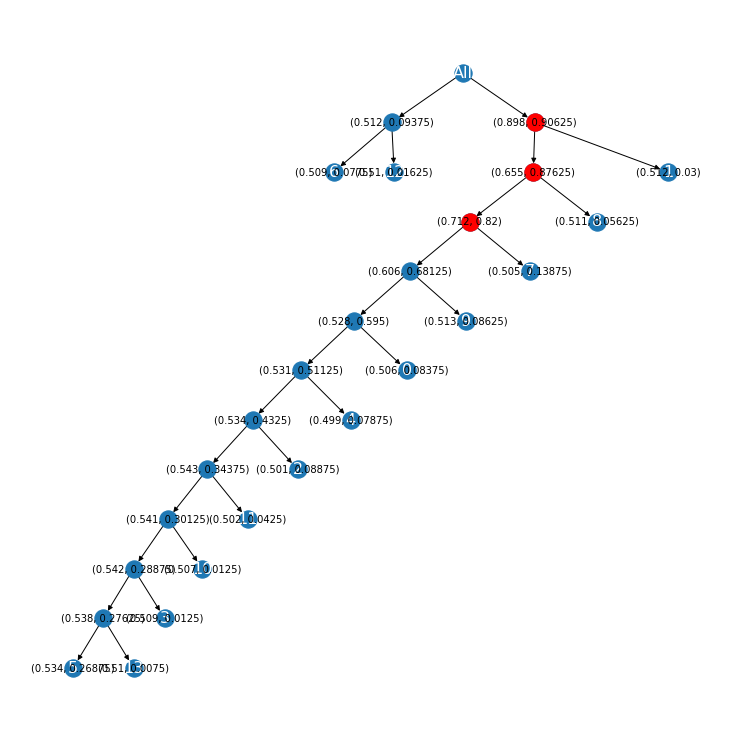

In [40]:
# show loss
plt.figure(figsize=(10,10))
pos = graphviz_layout(G, prog='dot', root='All')
nx.draw(G, pos, with_labels=False, arrows=True)
labels = dict() 
for node in G.nodes():
    if len(node.split('_'))==1:
        #set the node name as the key and the label as its value 
        labels[node] = node
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='w')

loss_labels = dict() 
for node_idx, node in list(enumerate(G.nodes()))[:-1]:
    loss_labels[node] = (round(float(losses[node_idx]), 3), fractionRows[node_idx])
nx.draw_networkx_nodes(G, pos, outliers, node_color='r')
nx.draw_networkx_labels(G, pos, loss_labels, font_color='black', font_size=10)
plt.show()

In [41]:
utility = dict()
for node_idx, node in list(enumerate(G.nodes()))[:-1]:
    cluster_ids = node.split('_')
    idxs = X_train_orig[X_train_orig['cluster']==int(cluster_ids[0])].index
    if len(cluster_ids) > 1:
        for cluster_id in cluster_ids:
            idxs = idxs.union(X_train_orig[X_train_orig['cluster']==int(cluster_id)].index)
    util = 1/len(idxs)*second_infs[node_idx]/spd_0*loss_0/(loss_0-losses[node_idx])
    utility[node] = round(util, 4)

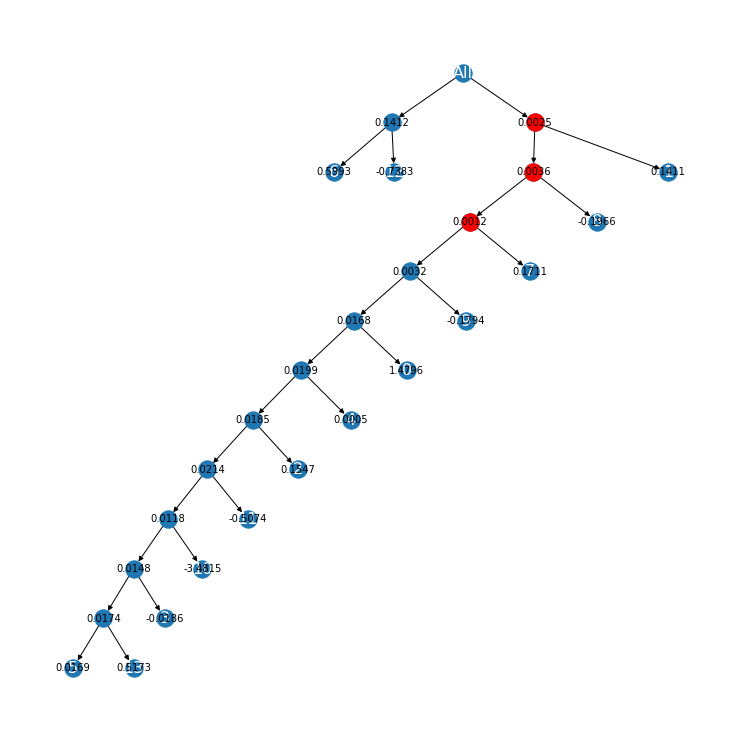

In [42]:
# show utility
plt.figure(figsize=(10,10))
pos = graphviz_layout(G, prog='dot', root='All')
nx.draw(G, pos, with_labels=False, arrows=True)
labels = dict() 
for node in G.nodes():
    if len(node.split('_'))==1:
        #set the node name as the key and the label as its value 
        labels[node] = node
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='w')
nx.draw_networkx_nodes(G, pos, outliers, node_color='r')
nx.draw_networkx_labels(G, pos, utility, font_color='black', font_size=10)
plt.show()

In [43]:
max_util_node_idx = np.argmax([utility[i] for i in list(G.nodes())[:-1] if not(i in outliers)])

In [45]:
def get_all_leaf_successors(node):
    successors = []
    if len(node.split('_')) == 1:
        successors.append(node)
    else:
        for node in list(G.successors(node)):
            for node_successor in get_all_leaf_successors(node):
                if len(node_successor.split('_')) == 1:
                    successors.append(node_successor)
    return successors

def get_neighbour(node):
    parent = list(G.predecessors(node))[0]
    children_of_parent = set(G.successors(parent))
    children_of_parent.remove(node)
    return children_of_parent[0]

def get_node_idx(node):
    for node_idx, node_name in list(enumerate(G.nodes()))[:-1]:
        if node_name == node:
            return node_idx

In [49]:
# selected_node = '5_13_3_10_11'
leaves = [(node, second_infs[node_idx]) for node_idx, node in list(enumerate(G.nodes()))[:-1] if\
          ((len(node.split('_'))==1)and not(node in outliers))]
leaf_second_infs = [i[1] for i in leaves]
selected_node = leaves[np.argmax(leaf_second_infs)][0]
selected_node_inf = leaves[np.argmax(leaf_second_infs)][1]
selected_node_idx = get_node_idx(selected_node)

In [50]:
current_second_inf = second_infs[selected_node_idx]
merged_node_idx = get_node_idx(list(G.predecessors(selected_node))[0])
merged_second_inf = second_infs[merged_node_idx]

while (merged_second_inf > current_second_inf):
    selected_node = list(G.predecessors(selected_node))[0]
    selected_node_idx = get_node_idx(selected_node)
    current_second_inf = second_infs[selected_node_idx]
    merged_node_idx = get_node_idx(list(G.predecessors(selected_node))[0])
    merged_second_inf = second_infs[merged_node_idx]

In [51]:
selected_node
# selected_node = '13'

'5_13_3'

In [52]:
cluster_ids = get_all_leaf_successors(selected_node)
cluster_ids

['5', '13', '3']

In [53]:
idxs = X_train_orig[X_train_orig['cluster']==int(cluster_ids[0])].index
for cluster_id in cluster_ids:
    idxs = idxs.union(X_train_orig[X_train_orig['cluster']==int(cluster_id)].index)

In [54]:
y_train_new = np.zeros(y_train.shape)
X_train_new = X_train_no_preprocess.copy()
# X_train_new = X_train_orig.copy()
# del X_train_new['cluster']
y_train_new[X_train_orig['cluster'].isin(cluster_ids)] = 1

In [56]:
X_train_new.describe()

,status,duration,credit_hist,credit_amt,savings,employment,install_rate,debtors,residence,property,age,install_plans,num_credits,job,num_liable,telephone,foreign_worker,gender
count,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,1.567500,0.956250,1.462500,0.73875,1.125000,2.376250,2.967500,0.146250,2.852500,1.626250,0.201250,0.195000,1.406250,1.916250,1.145000,0.396250,0.962500,0.678750
std,1.257943,0.907119,1.079375,0.74242,1.595323,1.215126,1.123843,0.479738,1.090748,1.054965,0.401185,0.396449,0.573692,0.651741,0.352321,0.489423,0.190102,0.467249
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,2.000000,2.000000,0.000000,2.000000,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,2.000000,1.00000,0.000000,2.000000,3.000000,0.000000,3.000000,2.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000
75%,3.000000,1.000000,2.000000,1.00000,2.000000,4.000000,4.000000,0.000000,4.000000,3.000000,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000
max,3.000000,3.000000,4.000000,2.00000,4.000000,4.000000,4.000000,2.000000,4.000000,3.000000,1.000000,1.000000,4.000000,3.000000,2.000000,1.000000,1.000000,1.000000


In [57]:
X_train_new[X_train_orig['cluster']==13].describe()

,status,duration,credit_hist,credit_amt,savings,employment,install_rate,debtors,residence,property,age,install_plans,num_credits,job,num_liable,telephone,foreign_worker,gender
count,6.000000,6.000000,6.000000,6.0,6.000000,6.000000,6.000000,6.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0,6.000000,6.0,6.000000
mean,1.333333,0.166667,2.166667,0.0,1.333333,2.666667,3.166667,0.0,2.666667,1.833333,0.166667,0.166667,1.333333,1.333333,1.0,0.333333,1.0,0.666667
std,1.366260,0.408248,1.329160,0.0,2.065591,1.032796,1.329160,0.0,1.032796,0.752773,0.408248,0.408248,0.516398,0.516398,0.0,0.516398,0.0,0.516398
min,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.0,0.000000,1.0,0.000000
25%,0.250000,0.000000,2.000000,0.0,0.000000,2.250000,2.500000,0.0,2.250000,1.250000,0.000000,0.000000,1.000000,1.000000,1.0,0.000000,1.0,0.250000
50%,1.000000,0.000000,2.000000,0.0,0.000000,3.000000,4.000000,0.0,3.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.0,0.000000,1.0,1.000000
75%,2.500000,0.000000,2.750000,0.0,3.000000,3.000000,4.000000,0.0,3.000000,2.000000,0.000000,0.000000,1.750000,1.750000,1.0,0.750000,1.0,1.000000
max,3.000000,1.000000,4.000000,0.0,4.000000,4.000000,4.000000,0.0,4.000000,3.000000,1.000000,1.000000,2.000000,2.000000,1.0,1.000000,1.0,1.000000


In [59]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=None)
decision_tree.fit(X_train_new, y_train_new)

In [ ]:
fig = plt.figure(figsize=(40,40))
_ = sklearn.tree.plot_tree(decision_tree, 
                   feature_names=X_train_new.columns,  
                   class_names=['0', '1'],
                   filled=True)
plt.savefig('1.png')

In [ ]:
fig = plt.figure(figsize=(40,40))
_ = sklearn.tree.plot_tree(decision_tree, 
                   feature_names=X_train_new.columns,  
                   class_names=['0', '1'], max_depth=4,
                   filled=True)
plt.savefig('1.png')

In [125]:
def calc_entropy(ls):
    vc = ls.value_counts(normalize=True, sort=False)
    return -(vc * np.log(vc)/np.log(np.e)).sum()

def calc_entropy_upper_bound(num_unique):
    return np.log(num_unique)/np.log(np.e)

class Stack:
    def __init__(self):
        self._stack = list()

    def push(self, val):
        self._stack.append(val)
    
    def pop(self):
        return self._stack.pop()
    
    def __len__(self):
        return len(self._stack)

In [181]:
def hierarchical_clustering(df=X_train_new, percentage=0.8):
    G = nx.DiGraph()
    G.add_node(f'(0)All')
#     global stack_idx
#     global stack_node
    stack_idx = Stack()
    stack_node = Stack()
    stack_idx.push(df.index)
    stack_node.push(f'(0)All')
    node_id = 1
    while len(stack_idx)>0:
        entropies = []
        current_idxs = stack_idx.pop()
        current_node = stack_node.pop()
        subset = df.iloc[current_idxs]
        attrs = list(subset.columns)
        for attr in attrs:
            if len(subset[attr].unique()) > 1:
#                 print(attr, calc_entropy(subset[attr]))
                entropies.append((attr, calc_entropy(subset[attr])))
            else:
                entropies.append((attr, 0))
        max_entropy_idx = np.argmax([e[1] for e in entropies])
        max_entropy_attr = entropies[max_entropy_idx][0]
        max_entropy = entropies[max_entropy_idx][1]
        if (max_entropy==0) or (max_entropy < percentage*calc_entropy_upper_bound(len(subset[max_entropy_attr].unique()))):
#             print('################################')
            continue
        else:
            for attr_val in subset[max_entropy_attr].unique():
                split_set = subset[subset[max_entropy_attr]==attr_val]
                G.add_node(f'({node_id}){max_entropy_attr}_{attr_val}')
                G.add_edge(current_node, f'({node_id}){max_entropy_attr}_{attr_val}', label=str(len(split_set)))
#                 print(max_entropy_attr)
#                 print(f'{current_node} ---> ({node_id}){max_entropy_attr}_{attr_val}')
                stack_idx.push(split_set.index)
                stack_node.push(f'({node_id}){max_entropy_attr}_{attr_val}')
                node_id += 1
        print(len(stack_idx))
    return G

In [ ]:
X_train_new = X_train_no_preprocess.copy()
# X_train_new['label'] = y_train_new
predicates = X_train_new.columns
predicates

In [175]:
G_new = hierarchical_clustering(X_train_new, percentage=0.76)

10
13
11
11
12
14
13
11
10
12
13
11
11
11
14
15
15
14
13
13
15
14
14
14
15
14
14
14
12
12
14
12
11
12
15
13
14
13
14
13
13
13
13
13
11
10
11
14
16
15
13
12
12
12
13
11
12
11
11
13
10
9
9
10
13
13
13
12
11
12
14
14
12
12
11
12
11
12
10
11
11
11
10
11
10
10
11
10
9
10
9
10
10
8
10
13
13
12
13
12
13
11
12
12
11
12
13
12
10
12
9
9
10
13
12
12
11
10
10
9
10
8
10
13
13
11
11
9
10
8
9
10
9
7
9
10
10
8
8
7
8
11
10
8
9
9
8
8
10
11
8
9
8
7
6
6
6
7
6
7
10
11
10
9
12
12
12
12
11
12
11
12
12
11
10
11
10
10
10
9
9
10
7
9
12
13
13
13
12
13
14
12
12
13
11
12
12
11
11
10
11
12
8
8
9
10
10
9
10
9
8
9
10
10
10
7
8
8
7
6
7
6
7
10
10
9
9
10
9
9
10
8
8
8
7
8
9
8
8
6
7
8
6
5
6
9
8
8
8
7
8
9
9
9
11
11
10
9
8
9
7
7
8
8
9
7
6
6
7
8
9
8
8
9
8
8
9
8
6
6
5
6
7
8
6
6
7
6
5
5
6
6
5
6
9
11
10
10
9
9
9
9
8
9
10
9
10
8
8
9
7
8
12
13
14
12
10
9
9
9
8
8
7
7
8
7
7
8
9
8
6
8
7
7
7
7
7
4
4
5
6
6
4
4
5
8
11
12
9
9
8
7
7
9
9
8
9
10
9
7
8
9
8
8
7
8
7
6
7
7
7
5
6
9
10
10
8
8
7
8
7
8
9
9
10
9
8
7
7
8
8
9
7
8
7
7
6
7
9
8
6
7
8
7


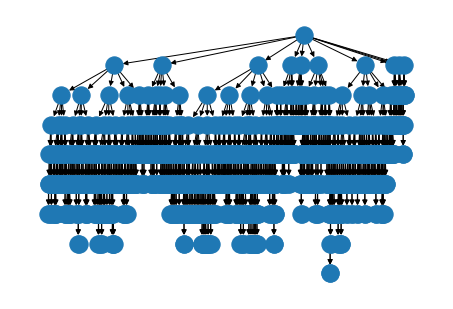

In [177]:
pos = graphviz_layout(G_new, prog='dot', root='All')
nx.draw(G_new, pos, with_labels=False, arrows=True)
# labels = dict() 
# for node in G.nodes():
#     if len(node.split('_'))==1:
#         #set the node name as the key and the label as its value 
#         labels[node] = node
# nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='w')

# outlier_labels = dict() 
# for node_idx, node in list(enumerate(G.nodes()))[:-1]:
#     if node in outliers:
#         #set the node name as the key and the label as its value 
#         outlier_labels[node] = fractionRows[node_idx]
# nx.draw_networkx_nodes(G, pos, outliers, node_color='r')
# nx.draw_networkx_labels(G, pos, outlier_labels, font_color='black')
# plt.show()

In [180]:
len(list(G_new.nodes()))

1253

In [183]:
def hierarchical_clustering_new(df=X_train_new, percentage=0.8):
    G = nx.DiGraph()
    G.add_node(f'(0)All')
    stack_idx = Stack()
    stack_node = Stack()
    stack_idx.push(df.index)
    stack_node.push(f'(0)All')
    node_id = 1
    
    current_idxs = stack_idx.pop()
    current_node = stack_node.pop()
    subset = df.iloc[current_idxs]
    max_entropy_attr = 'age'
    for attr_val in subset[max_entropy_attr].unique():
        split_set = subset[subset[max_entropy_attr]==attr_val]
        G.add_node(f'({node_id}){max_entropy_attr}_{attr_val}')
        G.add_edge(current_node, f'({node_id}){max_entropy_attr}_{attr_val}', label=str(len(split_set)))
        stack_idx.push(split_set.index)
        stack_node.push(f'({node_id}){max_entropy_attr}_{attr_val}')
        node_id += 1
    
    for _ in range(2):
        current_idxs = stack_idx.pop()
        current_node = stack_node.pop()
        subset = df.iloc[current_idxs]
        max_entropy_attr = 'label'
        for attr_val in subset[max_entropy_attr].unique():
            split_set = subset[subset[max_entropy_attr]==attr_val]
            G.add_node(f'({node_id}){max_entropy_attr}_{attr_val}')
            G.add_edge(current_node, f'({node_id}){max_entropy_attr}_{attr_val}', label=str(len(split_set)))
            stack_idx.push(split_set.index)
            stack_node.push(f'({node_id}){max_entropy_attr}_{attr_val}')
            node_id += 1
    
    
    while len(stack_idx)>0:
        entropies = []
        current_idxs = stack_idx.pop()
        current_node = stack_node.pop()
        subset = df.iloc[current_idxs]
        attrs = list(subset.columns)
        for attr in attrs:
            if len(subset[attr].unique()) > 1:
#                 print(attr, calc_entropy(subset[attr]))
                entropies.append((attr, calc_entropy(subset[attr])))
            else:
                entropies.append((attr, 0))
        max_entropy_idx = np.argmax([e[1] for e in entropies])
        max_entropy_attr = entropies[max_entropy_idx][0]
        max_entropy = entropies[max_entropy_idx][1]
        if (max_entropy==0) or (max_entropy < percentage*calc_entropy_upper_bound(len(subset[max_entropy_attr].unique()))):
#             print('################################')
            continue
        else:
            for attr_val in subset[max_entropy_attr].unique():
                split_set = subset[subset[max_entropy_attr]==attr_val]
                G.add_node(f'({node_id}){max_entropy_attr}_{attr_val}')
                G.add_edge(current_node, f'({node_id}){max_entropy_attr}_{attr_val}', label=str(len(split_set)))
#                 print(max_entropy_attr)
#                 print(f'{current_node} ---> ({node_id}){max_entropy_attr}_{attr_val}')
                stack_idx.push(split_set.index)
                stack_node.push(f'({node_id}){max_entropy_attr}_{attr_val}')
                node_id += 1
        print(len(stack_idx))
    return G

In [182]:
X_train_new = X_train_no_preprocess.copy()
X_train_new['label'] = y_train_new
predicates = X_train_new.columns
predicates

Index(['status', 'duration', 'credit_hist', 'purpose', 'credit_amt', 'savings',
       'employment', 'install_rate', 'debtors', 'residence', 'property', 'age',
       'install_plans', 'housing', 'num_credits', 'job', 'num_liable',
       'telephone', 'foreign_worker', 'gender', 'label'],
      dtype='object')

In [190]:
G_new = hierarchical_clustering_new(X_train_new, percentage=0.85)
len(list(G_new.nodes()))

6
9
8
9
8
7
6
5
6
7
6


39

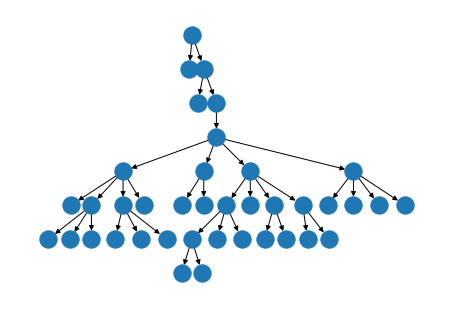

In [191]:
pos = graphviz_layout(G_new, prog='dot', root='All')
nx.draw(G_new, pos, with_labels=False, arrows=True)

In [192]:
nx.write_gexf(G_new,'space_partition.gexf')